# Customer Lifetime Value

In [1]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('OnlineRetail.csv',encoding = "ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

## Preprocessing

In [4]:
df.drop(['StockCode', 'Description', 'InvoiceNo'], axis=1, inplace=True)
df = df.loc[df['Country'] == 'United Kingdom']

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.year * 100 + df['InvoiceDate'].dt.month
df['InvoiceDate'] = df['InvoiceDate'].dt.date
df['Revenue'] = df['UnitPrice'] * df['Quantity']
df

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,6,2010-12-01,2.55,17850.0,United Kingdom,201012,15.30
1,6,2010-12-01,3.39,17850.0,United Kingdom,201012,20.34
2,8,2010-12-01,2.75,17850.0,United Kingdom,201012,22.00
3,6,2010-12-01,3.39,17850.0,United Kingdom,201012,20.34
4,6,2010-12-01,3.39,17850.0,United Kingdom,201012,20.34
...,...,...,...,...,...,...,...
541889,12,2011-12-09,1.95,15804.0,United Kingdom,201112,23.40
541890,8,2011-12-09,2.95,13113.0,United Kingdom,201112,23.60
541891,24,2011-12-09,1.25,13113.0,United Kingdom,201112,30.00
541892,24,2011-12-09,8.95,13113.0,United Kingdom,201112,214.80


In [6]:
df['InvoiceYearMonth'].max()

201112

In [7]:
df['InvoiceYearMonth'].min()

201012

#### Deciding the time frame usually depends on your industry, your tasks, your model and so on.
+ In this notebook, I will go ahead will 3 months
+ I will take 9 months of data, calculate RFM and use it for predicting next 3 months.
+ Therefore, i split data into 2 parts: 1-9/2011 for feature engineering and 10-12/2011 to label

In [8]:
# order customer
def sort_cluster(df, group_field, sort_field, ranked_field, by_ascending=True):
    df_star = df[[group_field,sort_field]].groupby(group_field).mean()
    df_star.sort_values(by=sort_field,ascending=by_ascending, inplace=True)
    df_star = df_star.reset_index()
    df_star[ranked_field] = df_star.index+1
    df_star.drop([sort_field], axis=1,inplace=True)
    return df_star

In [9]:
# split 2 parts: 9 months and 3 months
df_9_months = df.loc[(df['InvoiceYearMonth'] >= 201101) & (df['InvoiceYearMonth'] <= 201109)]
df_9_months

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
42481,10,2011-01-04,1.95,13313.0,United Kingdom,201101,19.50
42482,25,2011-01-04,0.42,13313.0,United Kingdom,201101,10.50
42483,25,2011-01-04,0.42,13313.0,United Kingdom,201101,10.50
42484,5,2011-01-04,2.10,13313.0,United Kingdom,201101,10.50
42485,10,2011-01-04,1.25,13313.0,United Kingdom,201101,12.50
...,...,...,...,...,...,...,...
370926,1,2011-09-30,8.29,NaN,United Kingdom,201109,8.29
370927,1,2011-09-30,5.79,NaN,United Kingdom,201109,5.79
370928,2,2011-09-30,0.83,NaN,United Kingdom,201109,1.66
370929,2,2011-09-30,0.83,NaN,United Kingdom,201109,1.66


In [10]:
df_3_months = df.loc[df['InvoiceYearMonth'] > 201109]
df_3_months

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
370931,48,2011-10-02,4.95,16353.0,United Kingdom,201110,237.6
370932,20,2011-10-02,1.25,16353.0,United Kingdom,201110,25.0
370933,4,2011-10-02,0.85,16591.0,United Kingdom,201110,3.4
370934,15,2011-10-02,7.08,16591.0,United Kingdom,201110,106.2
370935,4,2011-10-02,4.95,16591.0,United Kingdom,201110,19.8
...,...,...,...,...,...,...,...
541889,12,2011-12-09,1.95,15804.0,United Kingdom,201112,23.4
541890,8,2011-12-09,2.95,13113.0,United Kingdom,201112,23.6
541891,24,2011-12-09,1.25,13113.0,United Kingdom,201112,30.0
541892,24,2011-12-09,8.95,13113.0,United Kingdom,201112,214.8


In [11]:
def feature_engineering(df):
#     cluster model
    km = KMeans(n_clusters=5)
    
#     process Recency
    max_date = df['InvoiceDate'].max()
    # max_date
    df_recency = df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').max()
    df_recency['RecencyDay'] = (max_date - df_recency['InvoiceDate']).dt.days
    df_recency.drop('InvoiceDate', axis=1, inplace=True)
    df_recency = df_recency.reset_index()
    
    X = df_recency['RecencyDay'].to_numpy().reshape(-1,1)
    km.fit(X)
    
    df_cluster = pd.DataFrame({'ClusterRecency':km.labels_})
    df_recency_merge = df_recency.join(df_cluster)
    df_star_rec = sort_cluster(df_recency_merge,'ClusterRecency',
                               'RecencyDay', 'RecencyRanked', False)
    df_star_rec = pd.merge(df_recency_merge, df_star_rec, on='ClusterRecency')
    
#     Process Frequency
    df_frequency = df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').count()
    df_frequency = df_frequency.reset_index()
    df_frequency.columns = ['CustomerID', 'FrequencyCount']
    
    X = df_frequency['FrequencyCount'].to_numpy().reshape(-1,1)
    km.fit(X)
    
    df_cluster = pd.DataFrame({'ClusterFrequency':km.labels_})
    df_frequency_merge = df_frequency.join(df_cluster)
    df_star_fre = sort_cluster(df_frequency_merge, 'ClusterFrequency',
                               'FrequencyCount', 'FreRanked', True)
    df_star_fre = pd.merge(df_frequency_merge, df_star_fre, on='ClusterFrequency')

#     process Revenue
    df_revenue = df[['CustomerID', 'Revenue']].groupby('CustomerID').sum()
    df_revenue = df_revenue.reset_index()
    df_revenue.columns = ['CustomerID', 'Revenue']
    X = df_revenue['Revenue'].to_numpy().reshape(-1,1)
    km.fit(X)
    
    df_cluster = pd.DataFrame({'ClusterRevenue':km.labels_})
    df_revenue_merge = df_revenue.join(df_cluster)
    df_star_rev = sort_cluster(df_revenue_merge, 'ClusterRevenue',
                           'Revenue', 'RevRanked', True)
    df_star_rev = pd.merge(df_revenue_merge, df_star_rev, on='ClusterRevenue')

    overall_score = pd.merge(pd.merge(df_star_rev, df_star_fre, on='CustomerID'),df_star_rec, on='CustomerID')
    overall_score['Scored'] = overall_score['RevRanked'] + overall_score['FreRanked'] + overall_score['RecencyRanked']
    overall_score['Segment'] = 'Low'
    overall_score.loc[overall_score['Scored']>7, 'Segment'] = 'Mid'
    overall_score.loc[overall_score['Scored']>12, 'Segment'] = 'High'
    return overall_score


In [12]:
df_x = feature_engineering(df_9_months)
df_x

,CustomerID,Revenue,ClusterRevenue,RevRanked,FrequencyCount,ClusterFrequency,FreRanked,RecencyDay,ClusterRecency,RecencyRanked,Scored,Segment
0,12346.0,0.00,0,1,2,0,1,255,1,1,3,Low
1,12747.0,2063.13,0,1,55,0,1,39,0,4,6,Low
2,12749.0,2532.55,0,1,160,4,2,43,0,4,7,Low
3,12820.0,388.23,0,1,25,0,1,4,3,5,7,Low
4,12821.0,92.72,0,1,6,0,1,144,2,3,5,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
3124,15769.0,41519.92,3,4,90,0,1,8,3,5,10,Mid
3125,17511.0,57386.06,3,4,695,1,3,3,3,5,12,Mid
3126,17949.0,46169.82,3,4,65,0,1,0,3,5,10,Mid
3127,17450.0,152117.52,1,5,266,4,2,0,3,5,12,Mid


In [13]:
df_x.columns

Index(['CustomerID', 'Revenue', 'ClusterRevenue', 'RevRanked',
       'FrequencyCount', 'ClusterFrequency', 'FreRanked', 'RecencyDay',
       'ClusterRecency', 'RecencyRanked', 'Scored', 'Segment'],
      dtype='object')

In [14]:
df_x.drop(['ClusterRevenue', 'ClusterFrequency', 'ClusterRecency'], axis=1,
         inplace=True)
df_x

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Segment
0,12346.0,0.00,1,2,1,255,1,3,Low
1,12747.0,2063.13,1,55,1,39,4,6,Low
2,12749.0,2532.55,1,160,2,43,4,7,Low
3,12820.0,388.23,1,25,1,4,5,7,Low
4,12821.0,92.72,1,6,1,144,3,5,Low
...,...,...,...,...,...,...,...,...,...
3124,15769.0,41519.92,4,90,1,8,5,10,Mid
3125,17511.0,57386.06,4,695,3,3,5,12,Mid
3126,17949.0,46169.82,4,65,1,0,5,10,Mid
3127,17450.0,152117.52,5,266,2,0,5,12,Mid


In [15]:
df_3_months = df_3_months[['CustomerID', 'Revenue']].groupby('CustomerID').sum().reset_index()
df_3_months.rename(columns={'Revenue': 'Revenue_3m'}, inplace=True)
df_3_months

,CustomerID,Revenue_3m
0,12747.0,1426.61
1,12748.0,11751.68
2,12749.0,1335.65
3,12820.0,554.11
4,12824.0,397.12
...,...,...
2350,18276.0,323.36
2351,18277.0,110.38
2352,18282.0,77.84
2353,18283.0,974.21


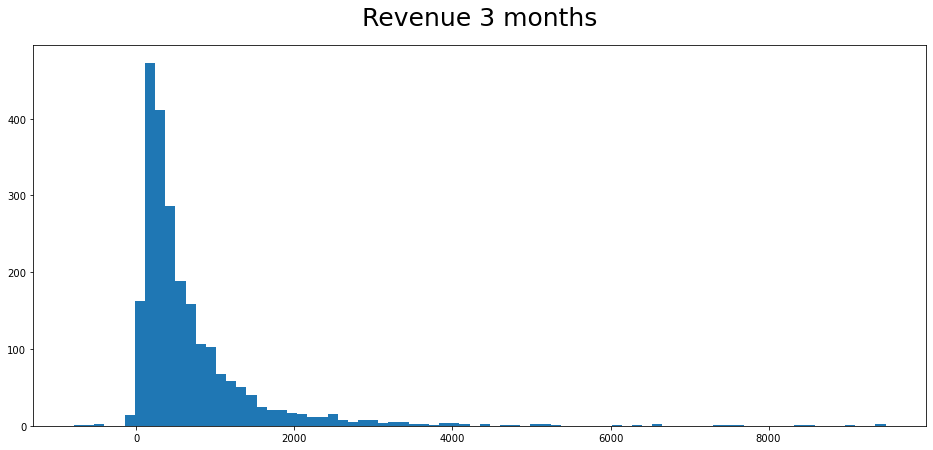

In [16]:
plt.figure(figsize=(16,7))
plt.hist(x=df_3_months.query('Revenue_3m < 10000')['Revenue_3m'], bins=80)
plt.xticks(rotation=0)
plt.title('Revenue 3 months', pad=20, fontsize=25)
plt.show()

- In this histogram i see some customer who has negative lifetime value and outliers
- So i will remove outliers to make my machine learning model more exactly. 

In [17]:
# Merge 2 dataframes to see how correlation between lifetime value and the feature
new_df = pd.merge(df_x, df_3_months, how='left')
new_df = new_df.fillna(0)
new_df

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Segment,Revenue_3m
0,12346.0,0.00,1,2,1,255,1,3,Low,0.00
1,12747.0,2063.13,1,55,1,39,4,6,Low,1426.61
2,12749.0,2532.55,1,160,2,43,4,7,Low,1335.65
3,12820.0,388.23,1,25,1,4,5,7,Low,554.11
4,12821.0,92.72,1,6,1,144,3,5,Low,0.00
...,...,...,...,...,...,...,...,...,...,...
3124,15769.0,41519.92,4,90,1,8,5,10,Mid,10212.00
3125,17511.0,57386.06,4,695,3,3,5,12,Mid,24104.56
3126,17949.0,46169.82,4,65,1,0,5,10,Mid,5267.02
3127,17450.0,152117.52,5,266,2,0,5,12,Mid,33335.81


In [18]:
# create new dataframe which have revenue of last 3 months not greater than 30000 to plot
df_graph = new_df.query("Revenue_3m <= 30000")
df_graph

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Segment,Revenue_3m
0,12346.0,0.00,1,2,1,255,1,3,Low,0.00
1,12747.0,2063.13,1,55,1,39,4,6,Low,1426.61
2,12749.0,2532.55,1,160,2,43,4,7,Low,1335.65
3,12820.0,388.23,1,25,1,4,5,7,Low,554.11
4,12821.0,92.72,1,6,1,144,3,5,Low,0.00
...,...,...,...,...,...,...,...,...,...,...
3122,14298.0,39548.00,4,1245,4,2,5,13,High,6624.98
3123,15311.0,44733.30,4,1757,4,3,5,13,High,12076.83
3124,15769.0,41519.92,4,90,1,8,5,10,Mid,10212.00
3125,17511.0,57386.06,4,695,3,3,5,12,Mid,24104.56


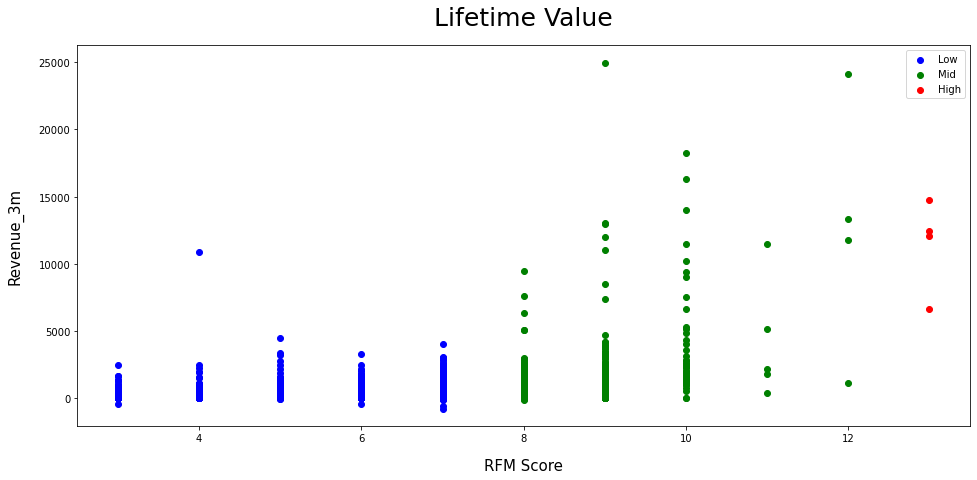

In [19]:
plt.figure(figsize=(16,7))
# Segment = Low
plt.scatter(x=df_graph.query("Segment == 'Low'")['Scored'], 
            y=df_graph.query("Segment == 'Low'")['Revenue_3m'], 
            label='Low', color = 'blue')
# Segment = Mid
plt.scatter(x=df_graph.query("Segment == 'Mid'")['Scored'], 
            y=df_graph.query("Segment == 'Mid'")['Revenue_3m'], 
            label='Mid', color = 'green')
# Segment = High
plt.scatter(x=df_graph.query("Segment == 'High'")['Scored'], 
            y=df_graph.query("Segment == 'High'")['Revenue_3m'], 
            label='High', color = 'red')

plt.xticks(rotation=0)
plt.xlabel('RFM Score', fontsize=15, labelpad=15)
plt.ylabel('Revenue_3m', fontsize=15, labelpad=15)
plt.title('Lifetime Value', pad=20, fontsize=25)
plt.legend()
plt.show()

- We can see correlation is ok here. High RFM Score =>> High Revenue_3m

#### Everything is ok now, let's build a machine learning to predict Lifetime Value Segment
- Low 
- Mid
- High
##### =>> Based on it to treat customers differently

In [20]:
new_df['Revenue_3m'].quantile(0.99)

6038.521599999785

In [21]:
# Remove outliers to make model more exactly, so i just get 99%
new_df = new_df[new_df['Revenue_3m'] < new_df['Revenue_3m'].quantile(0.99)] 

In [22]:
# Cluster
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_df[['Revenue_3m']])
new_df['PredSegment'] = kmeans.predict(new_df[['Revenue_3m']]) 

<ipython-input-22-56e8f2c1cf26>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['PredSegment'] = kmeans.predict(new_df[['Revenue_3m']])


In [23]:
new_df

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Segment,Revenue_3m,PredSegment
0,12346.0,0.00,1,2,1,255,1,3,Low,0.00,0
1,12747.0,2063.13,1,55,1,39,4,6,Low,1426.61,1
2,12749.0,2532.55,1,160,2,43,4,7,Low,1335.65,1
3,12820.0,388.23,1,25,1,4,5,7,Low,554.11,1
4,12821.0,92.72,1,6,1,144,3,5,Low,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
3116,18225.0,3772.66,2,199,2,2,5,9,Mid,1590.16,1
3117,18226.0,4711.50,2,210,2,7,5,9,Mid,480.60,0
3118,18229.0,5199.66,2,121,2,0,5,9,Mid,1424.04,1
3119,18251.0,4314.72,2,16,1,17,5,8,Mid,0.00,0


In [24]:
label_df = sort_cluster(new_df, 'PredSegment', 'Revenue_3m', 'Pred_Segment')
label_df

,PredSegment,Pred_Segment
0,0,1
1,1,2
2,2,3


In [25]:
new_df = pd.merge(new_df, label_df, on='PredSegment')
new_df.drop(['PredSegment'], axis=1, inplace=True)
# The label must consist of integer labels of form 0, 1, 2, ..., [num_class - 1] to add into model
new_df['Pred_Segment'] = new_df['Pred_Segment'] - 1
new_df

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Segment,Revenue_3m,Pred_Segment
0,12346.0,0.00,1,2,1,255,1,3,Low,0.00,0
1,12821.0,92.72,1,6,1,144,3,5,Low,0.00,0
2,12822.0,918.98,1,47,1,0,5,7,Low,0.00,0
3,12823.0,1759.50,1,5,1,4,5,7,Low,0.00,0
4,12826.0,891.02,1,63,1,1,5,7,Low,422.10,0
...,...,...,...,...,...,...,...,...,...,...,...
3092,18055.0,3122.70,2,167,2,14,5,9,Mid,1878.32,2
3093,18092.0,4302.88,2,49,1,16,5,8,Mid,1910.24,2
3094,18109.0,4482.09,2,318,2,2,5,9,Mid,2890.48,2
3095,18223.0,3426.61,2,187,2,2,5,9,Mid,2406.83,2


In [26]:
new_df.groupby('Pred_Segment')['Revenue_3m'].describe()

,count,mean,std,min,25%,50%,75%,max
Pred_Segment,,,,,,,,
0,2359.0,95.951645,154.817892,-788.38,0.0000,0.000,179.8150,517.80
1,610.0,946.578000,333.281774,519.48,667.8250,869.045,1195.4600,1807.59
2,128.0,2700.150000,839.572072,1832.72,2114.6675,2432.870,3024.4425,5267.02


In [27]:
print(2359 / (new_df.shape[0]))

0.7617048756861479


- I has biggest cluster is 0 with 2359 customer, 76% 

#### Before trainning, i should preprocessing data

In [28]:
# convert categorical to numerical to apply in model
df_use = pd.get_dummies(new_df)
df_use

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Revenue_3m,Pred_Segment,Segment_Low,Segment_Mid
0,12346.0,0.00,1,2,1,255,1,3,0.00,0,1,0
1,12821.0,92.72,1,6,1,144,3,5,0.00,0,1,0
2,12822.0,918.98,1,47,1,0,5,7,0.00,0,1,0
3,12823.0,1759.50,1,5,1,4,5,7,0.00,0,1,0
4,12826.0,891.02,1,63,1,1,5,7,422.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3092,18055.0,3122.70,2,167,2,14,5,9,1878.32,2,0,1
3093,18092.0,4302.88,2,49,1,16,5,8,1910.24,2,0,1
3094,18109.0,4482.09,2,318,2,2,5,9,2890.48,2,0,1
3095,18223.0,3426.61,2,187,2,2,5,9,2406.83,2,0,1


In [29]:
# Check correlation between feature and label
cor_matrix = df_use.corr()
cor_matrix

,CustomerID,Revenue,RevRanked,FrequencyCount,FreRanked,RecencyDay,RecencyRanked,Scored,Revenue_3m,Pred_Segment,Segment_Low,Segment_Mid
CustomerID,1.000000,-0.004699,-0.004255,0.008506,0.006504,0.008675,-0.013602,-0.009995,-0.009345,-0.003031,-0.001078,0.001078
Revenue,-0.004699,1.000000,0.797492,0.529187,0.494435,-0.296246,0.294225,0.514370,0.559240,0.472078,-0.574741,0.574741
RevRanked,-0.004255,0.797492,1.000000,0.506606,0.493876,-0.228164,0.229084,0.497652,0.515805,0.452109,-0.639876,0.639876
FrequencyCount,0.008506,0.529187,0.506606,1.000000,0.843674,-0.305849,0.304613,0.565647,0.444427,0.425318,-0.643502,0.643502
FreRanked,0.006504,0.494435,0.493876,0.843674,1.000000,-0.288938,0.288221,0.592535,0.435042,0.421321,-0.793344,0.793344
RecencyDay,0.008675,-0.296246,-0.228164,-0.305849,-0.288938,1.000000,-0.981016,-0.912544,-0.277146,-0.273097,0.354179,-0.354179
RecencyRanked,-0.013602,0.294225,0.229084,0.304613,0.288221,-0.981016,1.000000,0.927868,0.279022,0.277338,-0.368188,0.368188
Scored,-0.009995,0.514370,0.497652,0.565647,0.592535,-0.912544,0.927868,1.000000,0.435715,0.419269,-0.627182,0.627182
Revenue_3m,-0.009345,0.559240,0.515805,0.444427,0.435042,-0.277146,0.279022,0.435715,1.000000,0.889612,-0.479746,0.479746
Pred_Segment,-0.003031,0.472078,0.452109,0.425318,0.421321,-0.273097,0.277338,0.419269,0.889612,1.000000,-0.461034,0.461034


In [30]:
cor_matrix['Pred_Segment'].sort_values(ascending=False)

Pred_Segment      1.000000
Revenue_3m        0.889612
Revenue           0.472078
Segment_Mid       0.461034
RevRanked         0.452109
FrequencyCount    0.425318
FreRanked         0.421321
Scored            0.419269
RecencyRanked     0.277338
CustomerID       -0.003031
RecencyDay       -0.273097
Segment_Low      -0.461034
Name: Pred_Segment, dtype: float64

In [61]:
# Preparing and split data for model
from sklearn.model_selection import train_test_split
data_x = df_use.drop(['Revenue_3m', 'Pred_Segment'], axis=1)
data_y = df_use['Pred_Segment']
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1)

In [62]:
y_train

3045    2
2642    1
1673    0
26      0
1313    0
       ..
1101    0
2145    0
2902    1
1382    0
635     0
Name: Pred_Segment, Length: 2787, dtype: int64

#### Create model
#### XgBoost

In [63]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1, use_label_encoder=False).fit(X_train, y_train)

[14:54:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
print('Accuracy of XGB classifier on training data: {:.3f}'.format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test data: {:.3f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training data: 0.869
Accuracy of XGB classifier on test data: 0.823


In [65]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_pred = xgb_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8225806451612904


In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       243
           1       0.58      0.34      0.43        53
           2       0.67      0.29      0.40        14

    accuracy                           0.82       310
   macro avg       0.70      0.53      0.58       310
weighted avg       0.80      0.82      0.80       310




- It's looks good with cluster 0, but cluster 1, 2 are not good.
- Try with some another model

#### GradientBoosting

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
graboost = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=.2,
                                 max_depth=7, 
                                 random_state=0).fit(X_train, y_train)
y_gra = graboost.predict(X_test)
accuracy_score(y_test, y_gra)

0.7935483870967742

- It seems not better than Xgboost.
- Maybe i has mistake somewhere or should preprocessing and feature engineering more.

## Conclusion: 
### Ok, now i has model which predict customer lifetime value.
### So you can treat action base on cluster customer to get better.